In [1]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import global_add_pool, global_mean_pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [4]:
ATOM_PROPS = {
    1: [2.20, 13.60, 0.75, 0.31, 1.10], 
    6: [2.55, 11.26, 1.26, 0.76, 1.70],
    7: [3.04, 14.53, 0.00, 0.71, 1.55],
    8: [3.44, 13.62, 1.46, 0.66, 1.52],
    9: [3.98, 17.42, 3.40, 0.57, 1.47]
}

ATOM_PHYSICS = {
    1: [2.20, 6.42, 0.31],  # H
    6: [2.55, 5.00, 0.76],  # C
    7: [3.04, 7.27, 0.71],  # N
    8: [3.44, 6.08, 0.66],  # O
    9: [3.98, 7.01, 0.57]   # F
}
# HOMA 상수를 위한 데이터 (C-C, C-N, C-O 결합 등)
# R_opt: 이상적인 방향족 결합 길이, Alpha: 민감도 상수
HOMA_PARAMS = {
    (6, 6): (1.388, 257.7), # C-C (Benzene like)
    (6, 7): (1.334, 93.52), # C-N (Pyridine like)
    (6, 8): (1.265, 157.4)  # C-O (Furan like)
}

# BDE Table (이전과 동일)
BDE_TABLE = {
    (1, 1): 104, (1, 6): 99, (1, 7): 93, (1, 8): 111, (1, 9): 135,
    (6, 6): 83, (6, 7): 73, (6, 8): 86, (6, 9): 116,
    (7, 7): 39, (7, 8): 53, (8, 8): 35
}

KEY_CONFIG = {
    "atoms": "elements", 
    "R_coords": "RG", "TS_coords": "TSG", "P_coords": "PG",          
    "R_energy": { "H": "R_H", "G": "R_F", "E": "R_E" },
    "TS_energy": { "H": "TS_H", "G": "TS_F", "E": "TS_E" },
    "P_energy": { "H": "P_H", "G": "P_F", "E": "P_E" }
}
ATOM_MAP = {1: 0, 6: 1, 7: 2, 8: 3, 9: 4}

In [5]:
class POCIntegratedDataset(Dataset):
    def __init__(self, h5_path, limit=None):
        super(POCIntegratedDataset, self).__init__(None, transform=None, pre_transform=None)
        self.h5_path = h5_path
        if not os.path.exists(h5_path): raise FileNotFoundError(f"File not found: {h5_path}")
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)

    def len(self): return self.len_data

    def get_bde(self, z1, z2):
        pair = tuple(sorted((int(z1), int(z2))))
        return BDE_TABLE.get(pair, 80.0)

    def get(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            group = f[self.keys[idx]]
            atoms = group[KEY_CONFIG["atoms"]][()]
            z_values = torch.tensor([int(a) for a in atoms], dtype=torch.long)
            
            # [Feature 1] Extended Atomic Props (5 one-hot + 5 phys) = 10 dim
            x_list = []
            en_values = [] # 전기음성도 리스트 (전하 계산용)
            for z in z_values:
                z_int = int(z.item())
                one_hot = [0]*5
                one_hot[ATOM_MAP.get(z_int, 0)] = 1
                props = ATOM_PROPS.get(z_int, [0,0,0,0,0])
                x_list.append(one_hot + props)
                en_values.append(props[0]) # EN 저장
                
            x = torch.tensor(x_list, dtype=torch.float)
            en_tensor = torch.tensor(en_values, dtype=torch.float).unsqueeze(-1) # (N, 1)

            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            pos_P = torch.tensor(group[KEY_CONFIG["P_coords"]][()], dtype=torch.float)
            
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            
            # BEP Principle Inputs
            thermo_energy = e_P - e_R
            y_activation = e_TS - e_R

            num_nodes = x.size(0)
            row = torch.arange(num_nodes).repeat_interleave(num_nodes)
            col = torch.arange(num_nodes).repeat(num_nodes)
            mask = row != col
            edge_index = torch.stack([row[mask], col[mask]], dim=0)
            
            # Standard BDE
            bde_feat = []
            for r, c in edge_index.T:
                bde_feat.append(self.get_bde(z_values[r], z_values[c]))
            bde_feat = torch.tensor(bde_feat, dtype=torch.float).unsqueeze(-1)

            return Data(x=x, z=z_values, en=en_tensor, pos=pos_R, edge_index=edge_index, 
                        y_energy=y_activation, y_pos=pos_TS, 
                        pos_P=pos_P, thermo_energy=thermo_energy,
                        edge_bde=bde_feat)

In [6]:
class HOMALayer(nn.Module):
    """
    [Law: HOMA - Geometric Aromaticity]
    결합 길이의 편차를 이용하여 국소적 방향족성을 정량화합니다.
    HOMA = 1 - alpha * sum( (R_opt - R_i)^2 )
    """
    def __init__(self):
        super().__init__()
        # 파라미터 테이블을 텐서 딕셔너리로 변환은 복잡하므로, 
        # 단순화를 위해 C-C (가장 흔함) 기준으로 근사 계산 후 C-N, C-O 보정 계수 적용 방식 사용
        self.cc_opt = 1.388
        self.cc_alpha = 257.7
        
    def forward(self, z, edge_index, dist):
        row, col = edge_index
        # 탄소-탄소 결합인지 확인
        is_cc = (z[row] == 6) & (z[col] == 6)
        
        # HOMA 페널티 항: alpha * (R_opt - R)^2
        # C-C가 아니면 페널티를 0으로 처리 (일단 방향족성은 탄소 고리 위주로 판단)
        # 실제로는 heteroatom parameter도 써야 하지만, 학습 안정성을 위해 C-C backbone 위주로 구현
        
        diff = dist - self.cc_opt
        penalty = self.cc_alpha * (diff ** 2)
        
        # C-C 결합에만 적용, 나머지는 0 (영향 없음)
        homa_contrib = torch.where(is_cc.unsqueeze(-1), 1.0 - penalty, torch.zeros_like(dist))
        
        # 값이 너무 튀지 않게 클리핑 (-1 ~ 1)
        return torch.clamp(homa_contrib, -1.0, 1.0)

In [7]:
class ElectrostaticsLayer(nn.Module):
    """
    [Law: Coulombic Interaction]
    전기음성도 차이를 이용해 부분 전하(q)를 추정하고 쿨롱 에너지 계산
    E = k * q1 * q2 / r
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, en, edge_index, dist):
        # en: 전기음성도 (N, 1)
        row, col = edge_index
        
        # 1. 부분 전하 근사 (Partial Charge Approximation)
        # Gasteiger-Marsili 방식의 단순화: 전기음성도 차이에 비례하여 전하 이동
        # q_i ~ sum(chi_j - chi_i) (이웃에 대해)
        # 여기서는 엣지별 전하 차이(dipole source)를 바로 사용
        
        q_diff = en[row] - en[col] # (E, 1) - 전기음성도 차이 -> 쌍극자 모멘트 유사 성분
        
        # 2. 쿨롱 상호작용 (Coulomb Energy)
        # 전하 곱 / 거리
        # 여기서는 q_diff^2 (쌍극자 세기) / 거리 로 근사하여 정전기적 스트레스 계산
        elec_energy = (q_diff ** 2) / (dist + 0.1) # 0.1은 0나누기 방지
        
        return elec_energy

In [8]:
class SolvationLayer(nn.Module):
    """
    [Law: Born Solvation / Dielectric Screening]
    용매(Solvent)가 전하 분리된 상태(TS)를 안정화시키는 효과
    극성 용매(물, 알코올 등)라고 가정 (epsilon ~ 30-80)
    E_solv ~ - Q^2 / R
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, h, batch):
        # 분자의 전체적인 Polarity(극성)를 Hidden vector의 분산(Variance)으로 추정
        # 전하가 한쪽에 쏠려있으면(극성), h의 편차가 큼
        
        # Global Pooling으로 분자별 특징 추출
        # 여기서는 단순화를 위해 h 벡터의 norm을 "Effective Charge Size"로 가정
        mol_feat = global_add_pool(h, batch)
        effective_q2 = torch.norm(mol_feat, dim=-1, keepdim=True) ** 2
        
        # 분자 크기(Radius) 근사: 노드 개수(질량)에 비례
        # (정확히는 Gyration radius를 써야 하나 계산 비용상 Node count로 대체)
        mol_size = global_add_pool(torch.ones_like(batch, dtype=torch.float).unsqueeze(-1), batch)
        
        # Born Energy 식 적용
        e_solv = -1.0 * (effective_q2 / (mol_size + 1.0))
        return e_solv

In [9]:
class POCEnergyPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.homa = HOMALayer()
        self.electro = ElectrostaticsLayer()
        self.solvation = SolvationLayer()
        self.steric = StericLayer() # 이전 코드 StericLayer 재사용
        self.pauling = PaulingBondLayer() # 이전 코드 Pauling 재사용
        
        # Node MLP (Thermo + Solvation + Sterics)
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 3 + 1 + 1, hidden_dim), # +3(Thermo)+1(Steric)+1(Solv)
            nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)
        )
        
        # Edge MLP (All Physics Features)
        # Input: Hidden*2 + Dist + Pred_D + Gate + BO_R + BO_P + dBO + BDE + Break + Form + HOMA + Elec
        # Total: 512 + 11 = 523
        edge_in = (hidden_dim * 2) + 11
        
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_in, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, h, z, en, edge_index, pos_R, pos_P, gate_score, pred_delta_D, batch, thermo_energy, edge_bde):
        row, col = edge_index
        
        # 1. Global & Local Effects (Node Level)
        steric_R = self.steric(pos_R, edge_index)
        solv_energy = self.solvation(h, batch) # Solvation
        
        h_graph = global_add_pool(h, batch)
        steric_graph = global_add_pool(steric_R, batch)
        
        base_feat = torch.cat([h_graph, thermo_energy, steric_graph, solv_energy], dim=-1)
        base_energy = self.node_mlp(base_feat)
        
        # 2. Geometric & Electronic Physics (Edge Level)
        dist_R = (pos_R[row] - pos_R[col]).norm(dim=-1, keepdim=True)
        dist_P = (pos_P[row] - pos_P[col]).norm(dim=-1, keepdim=True)
        
        # Pauling BO
        bo_R = self.pauling(z, edge_index, dist_R)
        bo_P = self.pauling(z, edge_index, dist_P)
        delta_bo = bo_P - bo_R
        
        # HOMA (New!)
        homa_R = self.homa(z, edge_index, dist_R)
        
        # Electrostatics (New!)
        elec_E = self.electro(en, edge_index, dist_R)
        
        # Hammond / Bond Change
        is_bond_R = torch.sigmoid(10.0 * (2.0 - dist_R))
        is_bond_P = torch.sigmoid(10.0 * (2.0 - dist_P))
        bond_breaking = is_bond_R * (1 - is_bond_P)
        bond_forming = (1 - is_bond_R) * is_bond_P
        
        # 3. Assemble All Features
        edge_feat = torch.cat([
            h[row], h[col], 
            dist_R, pred_delta_D, gate_score,
            bo_R, bo_P, delta_bo, 
            edge_bde, 
            bond_breaking, bond_forming,
            homa_R, # 방향족성 기여
            elec_E  # 정전기적 기여
        ], dim=-1)
        
        edge_contrib = self.edge_mlp(edge_feat) * gate_score
        barrier_energy = global_add_pool(edge_contrib, batch[row])
        
        return base_energy + barrier_energy

In [10]:
class StereoPhysicsDataset(Dataset):
    def __init__(self, h5_path, limit=None):
        super(StereoPhysicsDataset, self).__init__(None, transform=None, pre_transform=None)
        self.h5_path = h5_path
        if not os.path.exists(h5_path): raise FileNotFoundError(f"File not found: {h5_path}")
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)

    def len(self): return self.len_data

    def get_bde(self, z1, z2):
        pair = tuple(sorted((int(z1), int(z2))))
        return BDE_TABLE.get(pair, 80.0)

    def get(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            group = f[self.keys[idx]]
            atoms = group[KEY_CONFIG["atoms"]][()]
            z_values = torch.tensor([int(a) for a in atoms], dtype=torch.long)
            
            # [수정됨] x, hsab, en 모두 생성
            x_list = []
            hsab_list = [] 
            en_list = [] # 전기음성도 따로 저장 (ElectrostaticsLayer용)
            
            for z in z_values:
                z_int = int(z.item())
                one_hot = [0]*5
                one_hot[ATOM_MAP.get(z_int, 0)] = 1
                
                # [EN, Hardness, Radius]
                props = ATOM_PHYSICS.get(z_int, [0,0,0]) 
                
                x_list.append(one_hot + props)
                
                # HSAB: [Chemical Potential(-EN), Hardness]
                hsab_list.append([-props[0], props[1]])
                
                # EN: [Electronegativity]
                en_list.append([props[0]]) 
            
            x = torch.tensor(x_list, dtype=torch.float)
            hsab = torch.tensor(hsab_list, dtype=torch.float)
            en = torch.tensor(en_list, dtype=torch.float) # 텐서 변환

            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            pos_P = torch.tensor(group[KEY_CONFIG["P_coords"]][()], dtype=torch.float)
            
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            
            thermo_energy = e_P - e_R
            y_activation = e_TS - e_R

            num_nodes = x.size(0)
            row = torch.arange(num_nodes).repeat_interleave(num_nodes)
            col = torch.arange(num_nodes).repeat(num_nodes)
            mask = row != col
            edge_index = torch.stack([row[mask], col[mask]], dim=0)
            
            bde_feat = []
            for r, c in edge_index.T:
                bde_feat.append(self.get_bde(z_values[r], z_values[c]))
            bde_feat = torch.tensor(bde_feat, dtype=torch.float).unsqueeze(-1)

            # Return에 en=en 추가됨
            return Data(x=x, z=z_values, hsab=hsab, en=en, 
                        pos=pos_R, edge_index=edge_index, 
                        y_energy=y_activation, y_pos=pos_TS, 
                        pos_P=pos_P, thermo_energy=thermo_energy,
                        edge_bde=bde_feat)

In [11]:
class StereoelectronicLayer(nn.Module):
    """
    [Law: Orbital Alignment] 궤도 정렬 효과
    결합의 방향성(Vector Cosine Similarity)을 이용하여
    반응물(R)과 생성물(P) 사이의 각도 변화가 급격할수록 에너지가 높음을 반영.
    (SN2 Backside attack이나 E2 Anti-periplanar 같은 기하학적 제약)
    """
    def __init__(self):
        super().__init__()

    def forward(self, pos_R, pos_P, edge_index):
        row, col = edge_index
        # 결합 벡터 계산
        vec_R = pos_R[col] - pos_R[row]
        vec_P = pos_P[col] - pos_P[row]
        
        # 벡터 정규화
        norm_R = F.normalize(vec_R, p=2, dim=-1)
        norm_P = F.normalize(vec_P, p=2, dim=-1)
        
        # 코사인 유사도 (Cosine Similarity): 궤도가 얼마나 틀어졌는가?
        # 1.0 = 그대로 유지, -1.0 = 완전히 뒤집힘 (Inversion, SN2)
        alignment = (norm_R * norm_P).sum(dim=-1, keepdim=True)
        
        # Alignment Score: 변화가 클수록(값이 작을수록) 반응성이 큼 (Strain or Transition)
        return alignment

In [12]:
class HSABInteractionLayer(nn.Module):
    """
    [Law: HSAB & Klopman-Salem]
    전자의 이동 방향과 에너지 갭 계산
    Delta E ~ (mu_A - mu_B)^2 / (eta_A + eta_B)
    """
    def __init__(self):
        super().__init__()

    def forward(self, hsab, edge_index):
        # hsab: [mu, eta]
        row, col = edge_index
        
        mu_i, eta_i = hsab[row, 0], hsab[row, 1]
        mu_j, eta_j = hsab[col, 0], hsab[col, 1]
        
        # 1. Chemical Potential Difference (Electrophilicity/Nucleophilicity mismatch)
        d_mu = (mu_i - mu_j).pow(2)
        
        # 2. Hardness Sum (Resistance to charge transfer)
        sum_eta = eta_i + eta_j
        
        # Klopman-Salem Energy Term (Approx)
        fmo_energy = d_mu / (sum_eta + 1e-6)
        
        return fmo_energy.unsqueeze(-1)

In [13]:
class StericLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1)
        density = 1.0 / (dist.pow(2) + 0.1)
        steric_score = torch.zeros(pos.size(0), 1, device=pos.device)
        steric_score.index_add_(0, row, density.unsqueeze(-1))
        return steric_score

In [14]:
class PaulingBondLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.r0_table = torch.tensor([0.0, 0.31, 0.0, 0.0, 0.0, 0.0, 0.76, 0.71, 0.66, 0.57]) 
    def forward(self, z, edge_index, dist):
        row, col = edge_index
        r0_i = self.r0_table.to(z.device)[z[row]]
        r0_j = self.r0_table.to(z.device)[z[col]]
        r0_sum = (r0_i + r0_j).unsqueeze(-1)
        bond_order = torch.exp((r0_sum - dist) / 0.3)
        return bond_order

In [15]:
class DeepGCPNet(nn.Module):
    def __init__(self, node_dim, hidden_dim, num_layers=4):
        super().__init__()
        self.embedding = nn.Linear(node_dim, hidden_dim)
        # GNN Layer 정의 (생략된 DeepGCPLayer는 이전 코드와 동일하게 사용)
        self.layers = nn.ModuleList([DeepGCPLayer(hidden_dim) for _ in range(num_layers)])
    def forward(self, x, pos, edge_index):
        h = self.embedding(x)
        for layer in self.layers: h = layer(h, pos, edge_index)
        return h

In [16]:
class DeepGCPLayer(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.message_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.update_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)
    def forward(self, h, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        edge_feat = torch.cat([h[row], h[col], dist], dim=-1)
        aggr_msg = torch.zeros_like(h)
        aggr_msg.index_add_(0, row, self.message_mlp(edge_feat))
        return self.norm(h + self.update_mlp(torch.cat([h, aggr_msg], dim=-1)))

In [17]:
class SigmoidGating(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 1), nn.Sigmoid()
        )
    def forward(self, h, edge_index, pos):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        return self.gate_mlp(torch.cat([h[row], h[col], dist], dim=-1))

In [18]:
class StructureDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1)
        )
    def forward(self, h, edge_index, gate_score):
        row, col = edge_index
        return self.mlp(torch.cat([h[row], h[col]], dim=-1)) * gate_score

In [19]:
class StereoElectronicPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.pauling = PaulingBondLayer()
        self.steric = StericLayer()
        self.stereo = StereoelectronicLayer() # New
        self.hsab = HSABInteractionLayer()   # New
        
        # Node MLP
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 3 + 1, hidden_dim), 
            nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)
        )
        
        # Edge MLP
        # Features: Hidden(2)*256 + Dist(1) + PredD(1) + Gate(1) + BO_R(1) + BO_P(1) + dBO(1) 
        #           + BDE(1) + Break(1) + Form(1) + Alignment(1) + FMO(1)
        # Total: 512 + 11 = 523
        edge_in = (hidden_dim * 2) + 11
        
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_in, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, h, z, hsab, edge_index, pos_R, pos_P, gate_score, pred_delta_D, batch, thermo_energy, edge_bde):
        row, col = edge_index
        
        # 1. Node Level Physics
        steric_R = self.steric(pos_R, edge_index)
        h_graph = global_add_pool(h, batch)
        steric_graph = global_add_pool(steric_R, batch)
        base_feat = torch.cat([h_graph, thermo_energy, steric_graph], dim=-1)
        base_energy = self.node_mlp(base_feat)
        
        # 2. Edge Level Physics
        dist_R = (pos_R[row] - pos_R[col]).norm(dim=-1, keepdim=True)
        dist_P = (pos_P[row] - pos_P[col]).norm(dim=-1, keepdim=True)
        
        # Pauling BO
        bo_R = self.pauling(z, edge_index, dist_R)
        bo_P = self.pauling(z, edge_index, dist_P)
        delta_bo = bo_P - bo_R
        
        # Hammond (Bond Change)
        is_bond_R = torch.sigmoid(10.0 * (2.0 - dist_R))
        is_bond_P = torch.sigmoid(10.0 * (2.0 - dist_P))
        bond_breaking = is_bond_R * (1 - is_bond_P)
        bond_forming = (1 - is_bond_R) * is_bond_P
        
        # [New] Stereoelectronic Alignment (Vector Angle Change)
        alignment = self.stereo(pos_R, pos_P, edge_index)
        
        # [New] HSAB / FMO Interaction
        fmo_energy = self.hsab(hsab, edge_index)
        
        # 3. Feature Assembly
        edge_feat = torch.cat([
            h[row], h[col], 
            dist_R, pred_delta_D, gate_score,
            bo_R, bo_P, delta_bo, 
            edge_bde, 
            bond_breaking, bond_forming, # Hammond
            alignment, # Stereoelectronics
            fmo_energy # HSAB
        ], dim=-1)
        
        edge_contrib = self.edge_mlp(edge_feat) * gate_score
        barrier_energy = global_add_pool(edge_contrib, batch[row])
        
        return base_energy + barrier_energy

In [20]:
class MultiEnergyModel(nn.Module):
    def __init__(self, node_dim=10, hidden_dim=256, num_layers=4):
        super().__init__()
        self.encoder = DeepGCPNet(node_dim, hidden_dim, num_layers)
        self.gating = SigmoidGating(hidden_dim)
        self.struct_decoder = StructureDecoder(hidden_dim)
        self.energy_predictor = POCEnergyPredictor(hidden_dim)

    def forward(self, data):
        h = self.encoder(data.x, data.pos, data.edge_index)
        gate_map = self.gating(h, data.edge_index, data.pos)
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)
        
        pred_delta_E3 = self.energy_predictor(
            h, data.z, data.en, data.edge_index, data.pos, data.pos_P, 
            gate_map, pred_delta_D, data.batch, 
            data.thermo_energy, data.edge_bde
        )
        return pred_delta_D, pred_delta_E3, gate_map

In [21]:
def train(h5_path, epochs=40, limit=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    
    dataset = StereoPhysicsDataset(h5_path, limit=limit)
    
    print("Computing stats...")
    loader_stat = DataLoader(dataset, batch_size=128, shuffle=False)
    all_E = []
    HARTREE_TO_KCAL = 627.5
    for b in loader_stat:
        all_E.append(b.y_energy.view(-1, 3) * HARTREE_TO_KCAL)
    all_E = torch.cat(all_E, dim=0)
    y_mean = all_E.mean(dim=0).to(device)
    y_std = all_E.std(dim=0).to(device)
    print(f"Mean: {y_mean.cpu().numpy()}")

    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    # node_dim=8 (One-hot 5 + Physics 3)
    model = MultiEnergyModel(node_dim=8, hidden_dim=256, num_layers=4).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
    
    history = {'loss': []}
    real_E3, pred_E3 = {'H':[], 'G':[], 'E':[]}, {'H':[], 'G':[], 'E':[]}
    
    print("\n[Start Stereoelectronic Training]")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for batch in pbar:
            batch = batch.to(device)
            optimizer.zero_grad()
            batch.thermo_energy = batch.thermo_energy.view(-1, 3) * HARTREE_TO_KCAL
            
            pred_d, pred_e3, gate = model(batch)
            
            dist_R = (batch.pos[batch.edge_index[0]] - batch.pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS = (batch.y_pos[batch.edge_index[0]] - batch.y_pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            
            e_target_kcal = batch.y_energy.view(-1, 3) * HARTREE_TO_KCAL
            e_target_norm = (e_target_kcal - y_mean) / y_std
            
            loss_struct = F.smooth_l1_loss(pred_d, dist_TS - dist_R)
            loss_energy = F.smooth_l1_loss(pred_e3, e_target_norm)
            loss_gate = F.binary_cross_entropy(gate, (torch.abs(dist_TS - dist_R)>0.1).float())
            
            total_loss = loss_struct + loss_energy + loss_gate
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += total_loss.item()
            pbar.set_postfix({'Loss': f"{total_loss.item():.4f}"})
            
            if epoch == epochs - 1:
                r = e_target_kcal.detach().cpu().numpy()
                p = (pred_e3.detach().cpu() * y_std.cpu() + y_mean.cpu()).numpy()
                for i, k in enumerate(['H', 'G', 'E']):
                    real_E3[k].extend(r[:, i])
                    pred_E3[k].extend(p[:, i])
                    
        avg_loss = epoch_loss / len(loader)
        history['loss'].append(avg_loss)
        scheduler.step(avg_loss)

    return history, real_E3, pred_E3

Device: cpu
Computing stats...


C:\Users\yeseo\anaconda3\envs\mlchem\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Mean: [69.403175 74.3915   72.29167 ]

[Start Stereoelectronic Training]


Epoch 40/40: 100%|███████████████████████████████████████████████████| 313/313 [07:27<00:00,  1.43s/batch, Loss=0.7865]


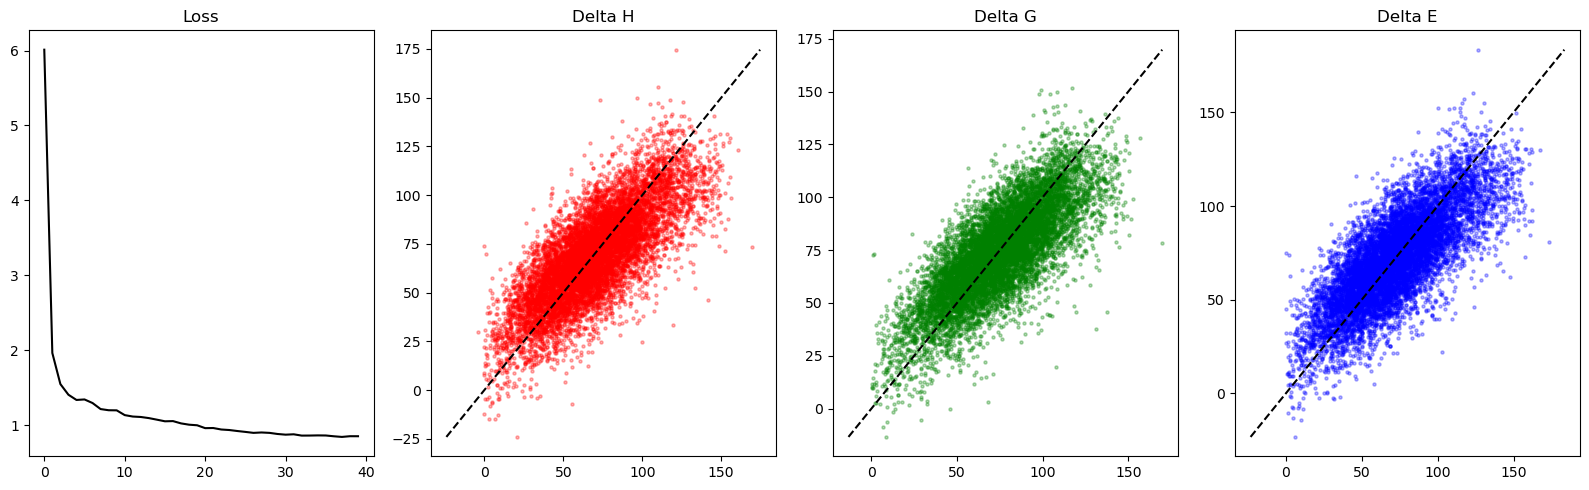

In [24]:
if __name__ == "__main__":
    import os
    base_dir = r"C:\Users\yeseo\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code"
    MY_H5_PATH = os.path.join(base_dir, "RGD1_CHNO.h5")
    
    if os.path.exists(MY_H5_PATH):
        hist, r_E3, p_E3 = train(MY_H5_PATH, epochs=40, limit=10000)
        
        if hist:
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 4, 1); plt.plot(hist['loss'], 'k-'); plt.title("Loss")
            titles, colors = ["Delta H", "Delta G", "Delta E"], ['r', 'g', 'b']
            keys = ['H', 'G', 'E']
            for i, k in enumerate(keys):
                plt.subplot(1, 4, i+2)
                plt.scatter(r_E3[k], p_E3[k], alpha=0.3, color=colors[i], s=5)
                mx = max(max(r_E3[k]), max(p_E3[k]))
                mn = min(min(r_E3[k]), min(p_E3[k]))
                plt.plot([mn, mx], [mn, mx], 'k--')
                plt.title(titles[i])
            plt.tight_layout()
            plt.show()
    else:
        print("파일을 찾을 수 없습니다.")

In [25]:
import numpy as np

def print_evaluation_report(real_dict, pred_dict):
    """
    학습 결과(정답 vs 예측)를 받아서 MAE, RMSE, R2, MSE를 계산하고 출력합니다.
    """
    print("\n" + "="*75)
    print(f"   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)")
    print("="*75)
    
    # 헤더 출력
    header = f"{'Energy Type':<15} | {'MAE':<10} | {'RMSE':<10} | {'MSE':<10} | {'R² Score':<10}"
    print(header)
    print("-" * 75)

    # H, G, E 각각에 대해 계산
    metrics = {}
    for key in ['H', 'G', 'E']:
        y_true = np.array(real_dict[key])
        y_pred = np.array(pred_dict[key])
        
        # 1. MAE (Mean Absolute Error)
        mae = np.mean(np.abs(y_true - y_pred))
        
        # 2. MSE (Mean Squared Error)
        mse = np.mean((y_true - y_pred)**2)
        
        # 3. RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mse)
        
        # 4. R2 Score (Coefficient of Determination)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8)) # 0으로 나누기 방지
        
        # 결과 저장
        metrics[key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # 행 출력
        label = f"Delta {key} (Δ{key})"
        print(f"{label:<15} | {mae:<10.4f} | {rmse:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

    print("="*75)
    
    # [화학적 해석]
    # 화학적 정확도(Chemical Accuracy)는 보통 1 kcal/mol 이내를 말합니다.
    avg_mae = np.mean([metrics[k]['MAE'] for k in ['H', 'G', 'E']])
    print(f"⭐ Average MAE: {avg_mae:.4f} kcal/mol")
    
    if avg_mae < 2.5:
        print("✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!")
        print("   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)")
    elif avg_mae < 5.0:
        print("⚠️ 학습이 잘 되었으나, 일부 복잡한 반응에서 오차가 있습니다.")
    else:
        print("❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.")
    print("="*75 + "\n")

# ==============================================================================
# [실행 방법] main 블록 안에서 train()이 끝난 후 호출하세요
# ==============================================================================
if __name__ == "__main__":
    # 위에서 이미 train을 실행해서 r_E3, p_E3가 있다고 가정합니다.
    # 만약 변수가 메모리에 없다면 다시 학습을 돌려야 합니다.
    
    if 'r_E3' in locals() and 'p_E3' in locals():
        print_evaluation_report(r_E3, p_E3)
    else:
        print("먼저 train() 함수를 실행하여 r_E3, p_E3 변수를 생성해주세요.")


   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)
Energy Type     | MAE        | RMSE       | MSE        | R² Score  
---------------------------------------------------------------------------
Delta H (ΔH)    | 14.4231    | 18.3305    | 336.0091   | 0.5774    
Delta G (ΔG)    | 13.4425    | 17.0498    | 290.6964   | 0.5879    
Delta E (ΔE)    | 15.0136    | 19.0024    | 361.0911   | 0.5792    
⭐ Average MAE: 14.2931 kcal/mol
❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.

